In [1]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:23: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 10

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [5]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
# load all models
%reload_ext autoreload
%autoreload 2
"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))"""
NN_model, history, X_test_scaled = train_and_evaluate_NN(X_train_eval, y_train_eval, X_eval, y_eval, X_test, y_test)

param_grid_alpha = {'alpha': 10.0}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha)

param_grid_xgb =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_best, best_params = optimize_and_train_xgb(X_train, y_train, X_eval, y_eval, param_grid_xgb)

param_grid_lgb =  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}

lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb)



C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 7s 789us/step - accuracy: 0.5164 - loss: 0.2498 - val_accuracy: 0.5306 - val_loss: 0.2484
Epoch 2/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 668us/step - accuracy: 0.5324 - loss: 0.2485 - val_accuracy: 0.5422 - val_loss: 0.2473
Epoch 3/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 6s 997us/step - accuracy: 0.5414 - loss: 0.2475 - val_accuracy: 0.5413 - val_loss: 0.2472
Epoch 4/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.5426 - loss: 0.2469 - val_accuracy: 0.5501 - val_loss: 0.2461
Epoch 5/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 6s 906us/step - accuracy: 0.5513 - loss: 0.2456 - val_accuracy: 0.5566 - val_loss: 0.2449
Restoring model weights from the end of the best epoch: 5.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_

In [7]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 3s 558us/step
Ridge Classifier:
Accuracy: 0.5155106630994624
Confusion Matrix:
[[78919 20353]
 [73995 21470]]
Precision: 51.335389618152696
Recall: 22.489917770910807
F1 Score: 31.277314841792435
MSE: 48.448933690053764
RMSE: 69.60526825611245


XGBoost Classifier:
Accuracy: 0.5136363402948593
Confusion Matrix:
[[52887 46385]
 [48328 47137]]
Precision: 50.40204443874169
Recall: 49.3762111768711
F1 Score: 49.883854445014734
MSE: 48.63636597051408
RMSE: 69.73977772441928


LightGBM Classifier:
Accuracy: 0.5177906612508152
Confusion Matrix:
[[55333 43939]
 [49965 45500]]
Precision: 50.872661814197386
Recall: 47.66144660346724
F1 Score: 49.2147276424523
MSE: 48.22093387491848
RMSE: 69.44129454072589


Neural Network:
Accuracy: 0.5143193127140707
Confusion Matrix:
[[62671 36601]
 [57979 37486]]
Precision: 50.597270776249545
Recall: 

In [8]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [28]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best,
    'NN': NN_model
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


In [10]:


"""def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):

    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        
        # Normalization factor to ensure absolute sum of values is 1
        num_assets = len(assets)
        if num_assets > 0:
            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets

        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value

# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days)"""


"def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):\n\n    for date_str, assets in portfolios.items():\n        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date\n        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days\n        \n        # Normalization factor to ensure absolute sum of values is 1\n        num_assets = len(assets)\n        if num_assets > 0:\n            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets\n\n        for asset in assets:\n            if asset in df.columns:\n                df.loc[start_date:end_date, asset] = value\n\n# Gather all best and worst assets for each date for each model\nportfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\nportfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\n\n\n\nfor name, model in models.items():\n    best_assets, worst_assets = predict_and_analyze_ext(model, X_test

In [44]:

def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days, returns_df, target_volatility=0.10):
    volatilities = calculate_annualized_volatility(returns_df.fillna(0))

    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        if start_date in volatilities.index:

            # asset vol on start date for buying assets
            asset_vols = volatilities.loc[start_date, assets]
            # Normalization factor to ensure absolute sum of values is 1
            weights = 1 / asset_vols
            normalized_weights = weights / weights.sum()  # Normalize weights
            
            # Adjust weights for shorting if portfolio_type is 'worst'
            if portfolio_type == 'worst':
                normalized_weights *= -1  # Negate weights for shorting

            # Get past returns for the assets
            past_returns = returns_df.loc[start_date - pd.DateOffset(days=hold_days):start_date, assets]

            # Calculate portfolio volatility and determine leverage factors    
            port_vol = calculate_portfolio_volatility(normalized_weights, past_returns)
            leverage = determine_leverage_factors(port_vol, target_volatility)
            adjusted_weights = apply_leverage(normalized_weights, leverage)  
             
            df[assets] = df[assets].astype(float) 
            df.loc[start_date:end_date, assets] = adjusted_weights.values

    
model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}

# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days, df_read)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days, df_read)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 3s 414us/step


d:\master3\Master-thesis\Files\func.py:507: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


In [12]:
# test

volatilities = calculate_annualized_volatility(df_read.fillna(0))
ass = ['EQS_1', 'FI_2', 'FXD_3']
asset_vols = volatilities.loc['2011-01-25',ass ]

weights = 1 / asset_vols
normalized_weights = weights / weights.sum()  # Normalize weights
past_returns = df_read.loc[pd.to_datetime('2011-01-25') - pd.DateOffset(days=365):'2011-01-25', ass]

vols = calculate_portfolio_volatility(normalized_weights, past_returns)
leverage = determine_leverage_factors(vols)
adj_weights = apply_leverage(normalized_weights, leverage)
adj_ret = adj_weights*past_returns
volatility = adj_ret.std() * np.sqrt(252)
adj_weights.values



array([ 9.95257808, 33.79366787, 15.22661119])

In [13]:
%reload_ext autoreload
%autoreload 2

"""def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days, returns_df, target_volatility=0.10):
    volatilities = calculate_annualized_volatility(returns_df)
    
    # Convert df columns to float to handle weights correctly
    df.astype(float)
    
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str).normalize() + pd.DateOffset(days=2)
        end_date = start_date + pd.DateOffset(days=hold_days - 1)
        
        if start_date in volatilities.index:
            asset_vols = volatilities.loc[start_date, assets].dropna()
            if not asset_vols.empty:
                weights = 1 / asset_vols
                normalized_weights = weights / weights.sum()  # Normalize weights
                
                # Adjust weights for shorting if portfolio_type is 'worst'
                if portfolio_type == 'worst':
                    normalized_weights *= -1  # Negate weights for shorting

                past_returns = returns_df.loc[start_date - pd.DateOffset(days=365):start_date, assets]

                daily_weights = df.loc[start_date:end_date, assets]  # Extract daily weights for the duration
                print(normalized_weights)
                # Apply the volatility calculation and leverage adjustment daily
                for idx, day_weights in daily_weights.iterrows():
                    portfolio_volatility = calculate_portfolio_volatility(day_weights, past_returns)
                    leverage_factor = determine_leverage_factors(portfolio_volatility, target_volatility)
                    adjusted_weights = apply_leverage(day_weights, leverage_factor)
                    df.loc[idx, assets] = adjusted_weights.values


                for single_date in pd.date_range(start_date, end_date):
                    if single_date in df.index:
                        day_weights = normalized_weights.copy()
                        print(day_weights)
                        portfolio_volatility = calculate_portfolio_volatility(day_weights, past_returns)
                        leverage_factor = determine_leverage_factors(portfolio_volatility, target_volatility)
                        adjusted_weights = apply_leverage(day_weights, leverage_factor)
                        
                        # Assign the adjusted weights back to the DataFrame
                        df.loc[single_date, adjusted_weights.index] = adjusted_weights.values



                            

portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

   
    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', 252, df_read, 0.10)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', 252, df_read, 0.10)"""

"def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days, returns_df, target_volatility=0.10):\n    volatilities = calculate_annualized_volatility(returns_df)\n    \n    # Convert df columns to float to handle weights correctly\n    df.astype(float)\n    \n    for date_str, assets in portfolios.items():\n        start_date = pd.to_datetime(date_str).normalize() + pd.DateOffset(days=2)\n        end_date = start_date + pd.DateOffset(days=hold_days - 1)\n        \n        if start_date in volatilities.index:\n            asset_vols = volatilities.loc[start_date, assets].dropna()\n            if not asset_vols.empty:\n                weights = 1 / asset_vols\n                normalized_weights = weights / weights.sum()  # Normalize weights\n                \n                # Adjust weights for shorting if portfolio_type is 'worst'\n                if portfolio_type == 'worst':\n                    normalized_weights *= -1  # Negate weights for shorting\n\n          

In [45]:
xgb_weights = model_dfs['xgb']
lgb_weights = model_dfs['lgb']
ridge_weights = model_dfs['ridge']
NN_weights = model_dfs['NN']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read


In [46]:
xgb_cumulative_total_returns

todate
2011-01-05    0.000000
2011-01-06    0.000000
2011-01-07   -0.049897
2011-01-10   -0.066722
2011-01-11    0.136555
2011-01-12    0.207387
2011-01-13    0.166056
2011-01-14    0.313070
2011-01-17    0.263728
2011-01-18    0.545145
2011-01-19    0.836113
2011-01-20    1.613274
2011-01-21    1.485904
2011-01-24    1.161537
2011-01-25    0.907234
2011-01-26    0.901685
2011-01-27    1.187020
2011-01-28    0.772281
2011-01-31    0.577075
2011-02-01    1.184822
2011-02-02    1.366826
2011-02-03    1.071379
2011-02-04    1.686080
2011-02-07    1.713785
2011-02-08    2.076523
2011-02-09    2.186029
2011-02-10    1.622832
2011-02-11    1.233854
2011-02-14    1.671376
2011-02-15    1.492836
2011-02-16    1.378875
2011-02-17    1.137525
2011-02-18    1.283395
2011-02-21    1.174219
2011-02-22    1.036786
2011-02-23    1.164001
2011-02-24    1.013923
2011-02-25    1.023634
2011-02-28    1.042625
2011-03-01    1.539683
2011-03-02    1.707283
2011-03-03    1.195890
2011-03-04    1.400403
2011

In [47]:


xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)



In [48]:
xgb_trade_volume.sum()

53263

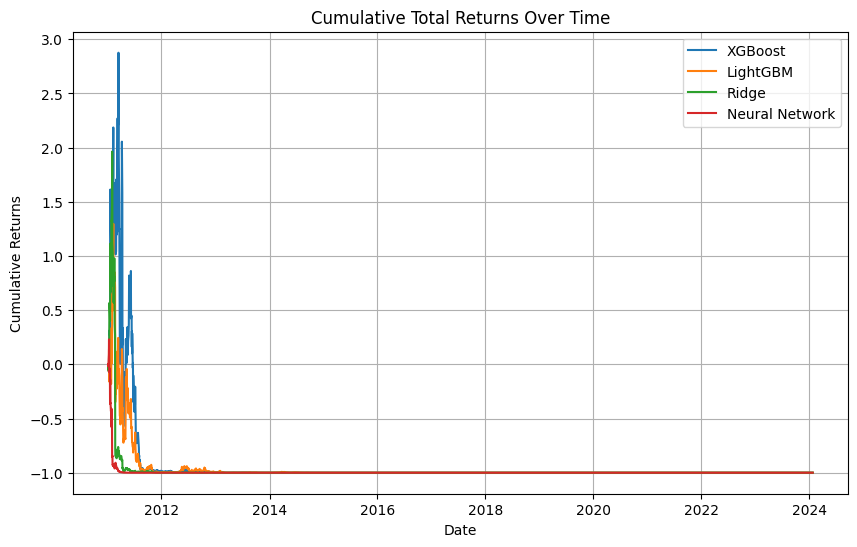

In [49]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)

# Calculate the cumulative total returns for each model
xgb_cumulative_total_returns = (1 + xgb_total_returns).cumprod() - 1
lgb_cumulative_total_returns = (1 + lgb_total_returns).cumprod() - 1
ridge_cumulative_total_returns = (1 + ridge_total_returns).cumprod() - 1
NN_cumulative_total_returns = (1 + NN_total_returns).cumprod() - 1


# use cumsum 
#xgb_cumulative_total_returns = xgb_total_returns.cumsum()
#lgb_cumulative_total_returns = lgb_total_returns.cumsum()
#ridge_cumulative_total_returns = ridge_total_returns.cumsum()
#NN_cumulative_total_returns = NN_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [19]:
xgb_total_returns.tail(125)

todate
2023-07-31    0.036706
2023-08-01   -0.243525
2023-08-02   -0.036048
2023-08-03   -0.234423
2023-08-04    0.093193
2023-08-07    0.029215
2023-08-08    0.152155
2023-08-09    0.101203
2023-08-10   -0.024803
2023-08-11   -0.112787
2023-08-14    0.074591
2023-08-15    0.073517
2023-08-16    0.089522
2023-08-17    0.008236
2023-08-18    0.099170
2023-08-21    0.015789
2023-08-22   -0.017093
2023-08-23    0.039364
2023-08-24   -0.127260
2023-08-25    0.045362
2023-08-28   -0.000757
2023-08-29   -0.031934
2023-08-30   -0.064624
2023-08-31   -0.055447
2023-09-01   -0.004888
2023-09-04   -0.072834
2023-09-05    0.103224
2023-09-06    0.045930
2023-09-07    0.143094
2023-09-08    0.047807
2023-09-11   -0.037659
2023-09-12   -0.037332
2023-09-13    0.017365
2023-09-14    0.384723
2023-09-15   -0.200946
2023-09-18   -0.119628
2023-09-19   -0.091468
2023-09-20   -0.162979
2023-09-21    0.005045
2023-09-22   -0.104502
2023-09-25   -0.044194
2023-09-26    0.213162
2023-09-27    0.017893
2023

In [35]:
#print trade volume
print("XGBoost trade volume:")
print(xgb_trade_volume.sum())
print("\n")
print("LightGBM trade volume:")
print(lgb_trade_volume.sum())
print("\n")
print("Ridge trade volume:")
print(ridge_trade_volume.sum())
print("\n")
print("Neural Network trade volume:")
print(NN_trade_volume.sum())
print("\n")

XGBoost trade volume:
53263


LightGBM trade volume:
52336


Ridge trade volume:
53941


Neural Network trade volume:
53322




In [36]:
ridge_metrics = financial_metrics(ridge_total_returns)
lgb_metrics = financial_metrics(lgb_total_returns)
xgb_metrics = financial_metrics(xgb_total_returns)
NN_metrics = financial_metrics(NN_total_returns)

In [37]:
print("Ridge metrics:")
print(ridge_metrics)
print("\n")
print("LightGBM metrics:")
print(lgb_metrics)
print("\n")
print("XGBoost metrics:")
print(xgb_metrics)
print("\n")
print("Neural Network metrics:")
print(NN_metrics)


Ridge metrics:
{'Average Yearly Return': 1.1122562837951206, 'Average Yearly Standard Deviation': 2.9265510385559046, 'Sharpe Ratio': 0.38005702587847545, 'Max Drawdown': -58.397298546930315, 'Volatility': 2.9265510385559046, 'Calmar Ratio': 0.019046365353720406, 'Skewness': -0.11332882625254175, 'Kurtosis': 2.302097017422547}


LightGBM metrics:
{'Average Yearly Return': 0.873044379127727, 'Average Yearly Standard Deviation': 2.868699479031352, 'Sharpe Ratio': 0.3043345549121514, 'Max Drawdown': -2.1706563787966333, 'Volatility': 2.868699479031352, 'Calmar Ratio': 0.402202940850419, 'Skewness': -0.488753240797341, 'Kurtosis': 4.739458830734838}


XGBoost metrics:
{'Average Yearly Return': 0.7416623086097006, 'Average Yearly Standard Deviation': 2.763811559849774, 'Sharpe Ratio': 0.26834763968134406, 'Max Drawdown': -1.3477450369873119, 'Volatility': 2.763811559849774, 'Calmar Ratio': 0.5502986753841653, 'Skewness': -0.4712322687148651, 'Kurtosis': 4.769781030131262}


Neural Network m

In [23]:
%reload_ext autoreload
%autoreload 2



In [24]:


def update_portfolio_with_volatility_control(df, portfolios, returns_df, hold_days, portfolio_type, target_volatility=0.10):
    volatilities = calculate_annualized_volatility(returns_df)
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str).normalize() + pd.DateOffset(days=2)
        end_date = start_date + pd.DateOffset(days=hold_days - 1)

        # Assuming returns_df already filtered for relevant assets
        past_returns = returns_df.loc[start_date-pd.DateOffset(days=365):start_date, assets]
        if start_date in df.index:
            asset_vols = volatilities.loc[start_date, assets].dropna()
            # Calculate weights based on inverse volatility
            if not asset_vols.empty:
                weights = 1 / asset_vols
                normalized_weights = weights / weights.sum()

                # Calculate portfolio volatility and adjust for target
                portfolio_volatility = calculate_portfolio_volatility(normalized_weights, past_returns)
                leverage_factor = determine_leverage_factor(portfolio_volatility, target_volatility)
                adjusted_weights = apply_leverage(normalized_weights, leverage_factor)

                # Apply weights based on portfolio_type
                 
                if portfolio_type == 'best': 
                    sign = 1
                else: 
                    -1
                for asset, weight in adjusted_weights.items():
                    df.loc[start_date:end_date, asset] = weight * sign


model_dfs_new = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


portfolios_best_new = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst_new = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best_new[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst_new[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_portfolio_with_volatility_control(model_dfs_new[name], portfolios_best_new[name], df_read, target_days,portfolio_type='best' , target_volatility=0.10)
    update_portfolio_with_volatility_control(model_dfs_new[name], portfolios_worst_new[name], df_read, target_days, portfolio_type='worst', target_volatility=0.10)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


ValueError: Weights and covariance matrix dimension mismatch.